# Learning about Kalman filter

**Resources:**

1) `Kalman Filter from Ground Up`; author Alex Becker; https://www.kalmanfilter.net

2) A very readable account of what problems can be solved with a `Kalman Filter` is chapter 1 of `Stochastic Models: Estimation and Control V.1` by Peter S. Maybeck; publisher Academic Press. Apart from the introductory chapter the book is not easy to read without a decent background. So I might come back reading more chapters of the book once I have a better grasp of the subject.


Practically everything in this notebook is based chapter 4 of `Kalman Filter from Ground Up`

---

# One Dimensional Kalman Filter / no process noise

## Example#1

we measure the weight of a gold bar. Measurements are denoted $z_n$ . The true (but unknown) weight is $x$. We can model the measurement by a sum of the true weight and some measurement error:

$$
z_n = x + e_n
$$

We do not know $e_n$ but if we are lucky we know its distribution function. To simplify things furter we assume that $e_n$ follows a gaussian distribution with known mean $\mu_x$ and standard deviation $\sigma_x$. With a gaussian distribution these to parameters/moments fully describe the distribution function.

$$\begin{align}
E(e_n) &= \mu_e \\
E( (e_n - \mu_e)^2 ) &= \sigma_e^2
\end{align}
$$

We take $N$ measurements to compute an estimatef weight $w_N$ of the gold bar.

$$\begin{aligned}
w_N &= \frac{1}{N} \cdot \sum_{n=1}^N z_n \\
&= x + \frac{1}{N} \cdot \sum_{n=1}^N e_n
\end{aligned}
$$

$$
E(w_N) = x + \frac{1}{N} \cdot \sum_{n=1}^N E(e_n) = x + \mu_e
$$

Assuming $\mu_e = 0$ (measurement error has zero mean) and therefore $E( e_n^2 ) = \sigma_e^2$ we get:

$$
E(w_N) = x 
$$

Now the variance $Var(w_N)$:

$$\begin{aligned}
Var(w_N) &= E( (w_N - x)^2 ) = E(w_N^2) - x^2 \\
&= E\left( \left(x + \frac{1}{N} \cdot \sum_{n=1}^N e_n\right)^2 \right) - x^2 \\
&= 2 \cdot x \cdot \frac{1}{N} \cdot \sum_{n=1}^N E(e_n) + \frac{1}{N^2} \cdot E\left( \left(\sum_{n=1}^N e_n \right)^2 \right) \\
&= \frac{1}{N^2} \cdot E\left( \left(\sum_{n=1}^N e_n \right)^2 \right) \\
&= \frac{1}{N^2} \cdot \sum_{n=1}^N \sum_{m=1}^N E\left(e_n \cdot e_m \right) \\
&= \frac{1}{N^2} \cdot \sum_{n=1}^N E\left(e_n^2\right) + \underbrace{\frac{1}{N^2} \cdot \underbrace{\sum_{n=1}^N \sum_{m=1}^N}_{n \neq m} E\left(e_n \cdot e_m \right) }_{= 0}\\
&= \frac{1}{N^2} \cdot \sum_{n=1}^N E\left(e_n^2\right) = \frac{1}{N} \cdot \sigma_e^2  \\
Var(w_N) &= \left(\frac{\sigma_e}{\sqrt{N}}\right)^2
\end{aligned}
$$

Thus averaging $N$ measurements to obtain an estimated weight $w_N$ has reduced the standard deviation $\sigma_e$ of the measurement error $e_n$ by a factor of $1/\sqrt{N}$.

**Visualisation**

The further illustrate the *weighing gold* example we shall provide a numerical example (closely related to what is presented in https://www.kalmanfilter.net).

We take $N=10$ measurement of a gold bar with nominal weight $x=1000 g$. Since the measurement is imprecise we assume a measurement error which follows a Gaussian distribution with a standard deviation of $\sigma = 10 g$.

Each measurement $w_n$ can be interpreted as a random variable drawn from normal distribution with mean $\mu = 1000 g$ and standard deviation $\sigma = 10 g$.

The probability density function of this distribution is then:

$$
p(w) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot exp\left( -\frac{\left(w-\mu\right)^2}{2 \cdot \sigma^2} \right)
$$

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

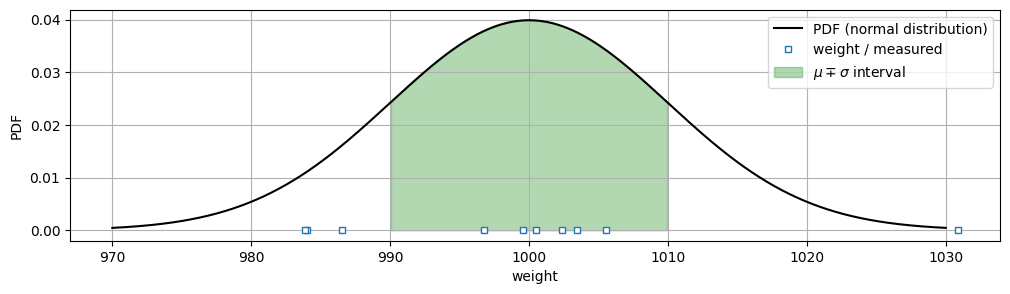

In [2]:
N = 10
mean_w = 1000
sigma = 10

# get the measurements by drawing samples from the distribution
w_measurements = stats.norm.rvs(loc=mean_w, scale=sigma, size=N)
w_limit_low = mean_w - 3 * sigma
w_limit_high = mean_w + 3 * sigma

# evaluate the probability density in the interval [w_limit_low, w_limit_high]
M = 1000
wp = np.linspace(w_limit_low, w_limit_high, M)
pdf = stats.norm.pdf(wp , loc=mean_w, scale=sigma)

range = (wp > (mean_w - sigma)) & (wp < (mean_w + sigma))

# display
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3))

ax1.plot(wp, pdf, color='k', label='PDF (normal distribution)')
ax1.plot(w_measurements, np.zeros_like(w_measurements), linestyle='', marker='s', markersize=4, markerfacecolor='w', label='weight / measured')
ax1.fill_between(wp[range], pdf[range], 0, color='g', alpha=0.3, label='$\mu \mp \sigma$ interval') 
ax1.set_xlabel('weight')
ax1.set_ylabel('PDF')
ax1.set_title('')
ax1.legend()
ax1.grid(True)

## Review / Tracking constant velocity aircraft

The prediction equations were:

$$\begin{aligned}
\hat{x}_{n+1, n} &= \hat{x}_{n, n} + \Delta t \cdot \hat{\dot{x}}_{n, n} \\
\hat{\dot{x}}_{n+1, n} &= \hat{\dot{x}}_{n, n} 
\end{aligned}
$$

Position $\hat{x}_{n, n}$ and velocity $\hat{\dot{x}}_{n, n}$ are now consider to be random variables. Moreover it shall be assumed that they are normally distributed.

Following the notation used in chapter 4 of https://www.kalmanfilter.net we will use:

$$\begin{aligned}
p^x_{n, n} &=Var\left(\hat{x}_{n, n}\right) \\
p^v_{n, n} &= Var\left(\hat{\dot{x}}_{n, n} \right)
\end{aligned}
$$

The superscripts $ ^x$ and $ ^v$ shall denote that these variances refer to either position or velocity.

The variances for the predicted position $\hat{x}_{n+1, n}$ and velocity $\hat{\dot{x}}_{n+1, n}$ follow directly from the prediction update equations:

$$\begin{aligned}
p^x_{n+1, n} &= p^x_{n, n} + \Delta t^2 \cdot p^v_{n, n} \\
p^v_{n+1, n}  &= p^v_{n, n} 
\end{aligned}
$$

Of course (just by time shifting) the equation can also be expressed as:

$$\begin{aligned}
p^x_{n, n-1} &= p^x_{n-1, n-1} + \Delta t^2 \cdot p^v_{n-1, n-1} \\
p^v_{n, n-1}  &= p^v_{n-1, n-1} 
\end{aligned}
$$

These equation are termed the `covariance extrapolation equation` .

**measurement**

For measurement $z_n$ it shall be assumed that it is subject to measurement noise too. The noise variance is denoted $r_n$.

**State update**

The position prediction $p^x_{n, n-1}$ and the position measurement $z_n$ are combined into a new position estimate.

$$
x_{n, n} = w_1 \cdot z_n + w_2 \cdot x_{n, n-1}
$$

with the constraint 

$$
w_1 + w_2 = 1
$$

The weighting factors are adjusted to minimise the variance $p^x_{n, n}$.

$$\begin{aligned}
p^x_{n, n} &= w_1^2 \cdot r_n + w_2^2 \cdot p^x_{n, n-1} \\
&= w_1^2 \cdot r_n + \left(1 - w_1 \right)^2 \cdot p^x_{n, n-1}
\end{aligned}
$$

Differentiation by $w_1$ is used to determine $w_1$ such as to minimise the variance $p^x_{n, n}$:

$$\begin{aligned}
\frac{d p^x_{n, n}}{w_1} &= 2 \cdot w_1 \cdot r_n - 2 \cdot \left(1 - w_1 \right) \cdot p^x_{n, n-1} =  2 \cdot w_1 \cdot \left(r_n + p^x_{n, n-1} \right) - 2 \cdot p^x_{n, n-1} \\
\end{aligned}
$$

$$\begin{aligned}
w_1 &= \frac{p^x_{n, n-1}}{r_n + p^x_{n, n-1}} \\
w_2 &= 1 - w_1 = \frac{r_n}{r_n + p^x_{n, n-1}}
\end{aligned}
$$

Inserting the $w_1$ and $w_2$ into the state update equation yields:

$$\begin{aligned}
x_{n, n} &= w_1 \cdot z_n + (1-w_1) \cdot x_{n, n-1}  \\
&= x_{n, n-1} + w_1 \cdot \left(z_n - x_{n, n-1}\right)  \\
&= x_{n, n-1} + \underbrace{\frac{p^x_{n, n-1}}{r_n + p^x_{n, n-1}}}_{K_n} \cdot \left(z_n - x_{n, n-1}\right) 
\end{aligned}
$$

With

$$
K_n = \frac{p^x_{n, n-1}}{r_n + p^x_{n, n-1}}
$$

the update equation becomes:

$$
x_{n, n} = x_{n, n-1} + K_n \cdot \left(z_n - x_{n, n-1}\right) 
$$

Factor $K_n$ is called the `Kalman-Gain`.

The result looks similar to the $\alpha - \beta$-filter. However this time the `Kalman-Gain` $K_n$ will not be a constant but it adapts to any changes in the values of the variances.

**variance $p^x_{n, n}$ of $x_{n, n}$**

$$\begin{aligned}
p^x_{n, n} &= w_1^2 \cdot r_n + w_2^2 \cdot p^x_{n, n-1}  \\
&= \left(\frac{p^x_{n, n-1}}{r_n + p^x_{n, n-1}}\right)^2 \cdot r_n + \left(\frac{r_n}{r_n + p^x_{n, n-1}}\right)^2 \cdot p^x_{n, n-1} \\
&= \frac{p^x_{n, n-1}}{\left(r_n + p^x_{n, n-1}\right)^2} \cdot p^x_{n, n-1} \cdot r_n + \frac{r_n}{\left(r_n + p^x_{n, n-1}\right)^2} \cdot p^x_{n, n-1} \cdot r_n \\
&= \underbrace{\frac{ r_n }{r_n + p^x_{n, n-1}}}_{1 - K_n} \cdot p^x_{n, n-1} \\
& \\
p^x_{n, n}&= \left(1 - K_n\right) \cdot p^x_{n, n-1}
\end{aligned}
$$

The equation is called the `covariance update equation`.

The next section of this notebook summarizes everything we know thus far about the `Kalman-Filter` in a single dimension.

---

## Summary / Kalman Filter in One Direction 

The equation are valid for constant velocity dynamics (it won't be tracking postiton of motion with time varying accelaration).

**State Update / Filtering Equation**

|c   | Equation | Equation Name |
|----|---------|--------------|
|State Update | $x_{n, n} = x_{n, n-1} + K_n \cdot \left(z_n - x_{n, n-1}\right)$ | State Update /Filtering Equation |
|             | $p^x_{n, n} = \left(1 - K_n\right) \cdot p^x_{n, n-1}$ | Covariance update |
|             | $K_n = \frac{p^x_{n, n-1}}{r_n + p^x_{n, n-1}}$ | Kalman Gain |
| State Prediction | $\hat{x}_{n+1, n} = \hat{x}_{n, n} + \Delta t \cdot \hat{\dot{x}}_{n, n} $ | Position Prediction|
|               | $\hat{\dot{x}}_{n+1, n} = \hat{\dot{x}}_{n, n} $  |  constant velocity prediction |
|               | $p^x_{n, n-1} = p^x_{n-1, n-1} + \Delta t^2 \cdot p^v_{n-1, n-1}$ | covariance extrapolation |
|               | $p^v_{n, n-1}  = p^v_{n-1, n-1} $ |  |


---

## Estimating the height of a building

example taken from chapter 4.2 of the book `Kalman Filter from Ground`; author Alex Becker.

The true height of a building is 50 m. A set of 10 successive measurements is available. The measurements are:

$49.03, 48.44, 55.21, 49.98, 50.6, 52.61, 45.87, 42.64, 48.26, 55.84$ 

But these measurement are subject to some measurement error. The standard deviation of the measurement error shall be $5m$. Its distribution shall be gaussion and its mean value $0$.

**initialisation**

The initial assumption about the heigth $\hat{x}_{0,0}$ has been chosen to 

$$
\hat{x}_{0,0} = 60 m
$$

(My personal choice would have been to take the first measurement as an initial value)

Since the initial estimate $\hat{x}_{0,0}$ is not very accurate we assume its variance $p_{0,0}$ to be:

$$
p_{0,0} = 225 \ m^2  
$$

(corresponding to a standard deviation of 15 m).

Since the height of the bulding does not change throughout all 10 measurements out first prediction will be:

$$
\hat{x}_{1,0} = \hat{x}_{0,0}  = 60 m
$$

Accordingly the variance of the prediction does not change:

$$
p_{1,0} = p_{0,0} = 225 \ m^2  
$$

**iteration#1**

With the first measurement $z_1 = 49.03 m$ and the measurement variance $r_1 = 25 m^2$ we compute the `Kalman Gain` $K_1$:

$$
K_1 = \frac{p_{1,0}}{p_{1,0} + r_1} = \frac{225}{225 + 25} = \frac{225}{250} = 0.9
$$

The estimate $\hat{x}_{1,1}$ of the current height becomes:

$$\begin{aligned}
\hat{x}_{1,1} &= \hat{x}_{1,0} + K_1 \cdot \left(z_1 -  \hat{x}_{1,0} \right) \\
&= 60 m  - 0.9 \cdot 10.97 \\
&= 50.13 m
\end{aligned}
$$

$$
p_{1, 1} = \left(1 - K_1\right) \cdot p_{1, 0} = 0.1 \cdot 225 \ m^2 = 22.5 \ m^2
$$

**iteration#2**

$$
p_{2,1} = p_{1,1} = 22.5 \ m^2  
$$

With the 2'nd measurement $z_2 = 48.44 m$ and the measurement variance $r_2 = 25 m^2$ we compute the `Kalman Gain` $K_2$:

$$
K_1 = \frac{p_{2,1}}{p_{2,1} + r_2} = \frac{22.5}{22.5 + 25} = \frac{22.5}{47.5} = 0.47
$$

The estimate $\hat{x}_{2,2}$ of the current height becomes:

$$\begin{aligned}
\hat{x}_{2,2} &= \hat{x}_{2,1} + K_2 \cdot \left(z_2 -  \hat{x}_{2,1} \right) \\
&= 50.13 m  - 0.47 \cdot 1.69 m \\
&= 49.33 m
\end{aligned}
$$

$$
p_{2, 2} = \left(1 - K_1\right) \cdot p_{2, 1} = 0.53 \cdot 22.5 \ m^2 = 11.925 \ m^2
$$

(in the book this value is incorrectly computed; but the basic procedure is still valid)

---